In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from plotnine import *
import numpy as np
import datetime
from scipy.stats import norm
from mizani import breaks

In [3]:
import datetime
import os
import pandas as pd
pd.set_option('display.max_rows',500)

import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

In [4]:
qry = """
  with source as (
    select crop_id, 
      requested_termination_at::date as requested_termination_at,
      
      nvl(yield_attributed_on,forecasted_yield_attributed_on) as yield_attributed_on,
      selected_at,
      case when selected_at is not null then 1 else 0 end as o_c_decision,
      case when o_c_decision=1 then greatest(sq_ft_years_planned - sq_ft_years,0) else 0 end as oc_sq_ft_years_recouped,
      case when o_c_decision=0 then greatest(sq_ft_years_planned - sq_ft_years,0) else 0 end as other_sq_ft_years_recouped
    from warehouse.dm_crops
    left join warehouse.f_cull_decisions using (crop_id)
    where outcome = 'terminated'
    and farm_id = 2
      and forecasted_yield_attributed_on between '2022-05-01' and '2022-12-31'
  )
  select yield_attributed_on,
    avg(o_c_decision) as oc_termination_proportion,
    sum(oc_sq_ft_years_recouped) as oc_sq_ft_years_recouped,
    sum(other_sq_ft_years_recouped) as other_sq_ft_years_recouped,
    div0(sum(oc_sq_ft_years_recouped),  (sum(oc_sq_ft_years_recouped) + sum(other_sq_ft_years_recouped))) as oc_spacetime_recouped_proportion
  from source
  group by yield_attributed_on
"""
df = pd.read_sql(qry,conn)

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [5]:
df.head()

,YIELD_ATTRIBUTED_ON,OC_TERMINATION_PROPORTION,OC_SQ_FT_YEARS_RECOUPED,OTHER_SQ_FT_YEARS_RECOUPED,OC_SPACETIME_RECOUPED_PROPORTION
0,2022-06-14,0.000000,0.000,38.354,0.000000
1,2022-09-02,0.157895,1.361,45.794,0.028862
2,2022-09-19,0.013514,0.116,29.277,0.003947
3,2022-05-08,0.000000,0.000,7.138,0.000000
4,2022-11-01,0.166667,0.018,10.771,0.001668


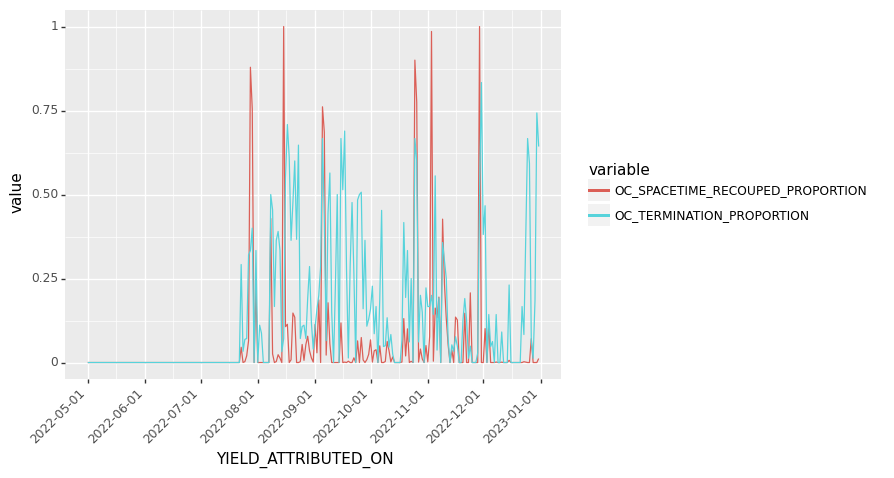

<ggplot: (362222352)>

In [6]:
(
    df
    .drop(['OC_SQ_FT_YEARS_RECOUPED','OTHER_SQ_FT_YEARS_RECOUPED'],axis=1)
    .pipe(lambda d: pd.melt(d, id_vars=['YIELD_ATTRIBUTED_ON']))
    .assign(YIELD_ATTRIBUTED_ON = lambda d: pd.to_datetime(d['YIELD_ATTRIBUTED_ON']))
    .pipe(lambda d: ggplot(d, aes(x='YIELD_ATTRIBUTED_ON',y='value',color='variable')) 
          + geom_line()
          + theme(axis_text_x=element_text(rotation=45,hjust=1)))
)

## Yield Impact

In [7]:
qry = """
-- the current yield metric is calculated at component level
-- so we need to redo the sum and divide to calculate at an overall level

with source as (
    select *, 
      yield_obs * spacetime_sqftyrs_obs as yield_obs_num,
      spacetime_sqftyrs_obs as yield_obs_denom,
      overseed_cohort_mass * OVERSEED_ADJUSTMENT_FACTOR as yield_est_num,
      div0(overseed_cohort_mass * overseed_adjustment_factor, yield_est) as yield_est_denom,
      div0(yield_obs_num,yield_obs_denom) as yield_obs_recalc,
      div0(yield_est_num, yield_est_denom) as yield_est_recalc

    from export.overseed_cull_yield
    where farm_id = 2 
      and week_starting_on between' 2022-01-20' and current_Date 
      and n_incomplete = 0 
),

summations as (
    select farm_id,
      week_starting_on, 
      sum(yield_obs_num) as yield_obs_num_sum,
      sum(yield_obs_denom) as yield_obs_denom_sum,
      sum(yield_est_num) as yield_est_num_sum,
      sum(yield_est_denom) as yield_est_denom_sum
    from source 
    group by farm_id, 
      week_starting_on
),

metrics as (
    select farm_id,
      week_starting_on,
      div0(yield_obs_num_sum, yield_obs_denom_sum) as "observed_yield",
      div0(yield_est_num_sum, yield_est_denom_sum) as "estimated_yield_wo_oc"
    from summations
    order by week_starting_on desc
),

impact as (
    select FARM_ID,
      week_starting_on,
      "observed_yield",
      "estimated_yield_wo_oc",
      "observed_yield" - "estimated_yield_wo_oc" as yield_diff,
      yield_diff/"estimated_yield_wo_oc"         as perc_yield_diff
    from metrics
),

oc_influence_source as (
    select crop_id, 
      requested_termination_at::date                                                         as requested_termination_at,
      nvl(yield_attributed_on,forecasted_yield_attributed_on)                                as yield_attributed_on,
      selected_at,       
      case when selected_at is not null then 1 else 0 end                                    as o_c_decision,
      case when o_c_decision=1 then greatest(sq_ft_years_planned - sq_ft_years,0) else 0 end as oc_sq_ft_years_recouped,
      case when o_c_decision=0 then greatest(sq_ft_years_planned - sq_ft_years,0) else 0 end as other_sq_ft_years_recouped
    from warehouse.dm_crops
      left join warehouse.f_cull_decisions using (crop_id)
    where outcome = 'terminated'
      and farm_id = 2
      and grow_1_position_id is not null
      and forecasted_yield_attributed_on between '2022-05-01' and '2022-12-31'
      and remediation_reason like 'Ag%' or remediation_reason = 'Overseed and Cull: Failure'
      
),

oc_influence as (
    select yield_attributed_on           as week_starting_on,
      avg(o_c_decision)                  as oc_termination_proportion,
      sum(oc_sq_ft_years_recouped)       as oc_sq_ft_years_recouped,
      sum(other_sq_ft_years_recouped)    as other_sq_ft_years_recouped,
      div0(sum(oc_sq_ft_years_recouped),  (sum(oc_sq_ft_years_recouped) + sum(other_sq_ft_years_recouped))) as oc_spacetime_recouped_proportion,
      div0(sum(other_sq_ft_years_recouped),  (sum(oc_sq_ft_years_recouped) + sum(other_sq_ft_years_recouped))) as other_spacetime_recouped_proportion
    from oc_influence_source
    
    group by week_starting_on
)

select *, 
  PERC_YIELD_DIFF * oc_termination_proportion        as OC_YIELD_IMPACT_CROP,
  PERC_YIELD_DIFF * oc_spacetime_recouped_proportion as OC_YIELD_IMPACT_SPACETIME,
  PERC_YIELD_DIFF * other_spacetime_recouped_proportion as OTHER_YIELD_IMPACT_SPACETIME
from impact join oc_influence using (week_starting_on)
"""

df = pd.read_sql(qry,conn)

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10


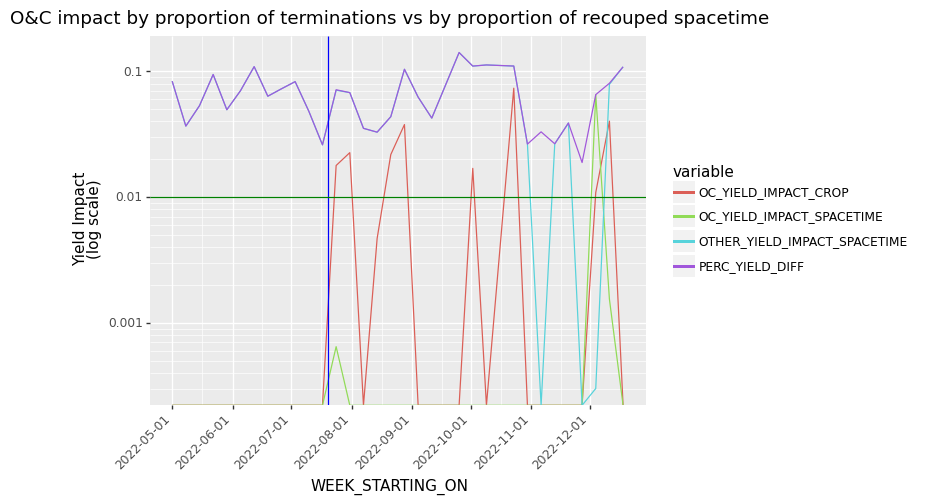

<ggplot: (362473735)>

In [8]:
(
    df
    .filter(items=['WEEK_STARTING_ON','PERC_YIELD_DIFF','OC_YIELD_IMPACT_CROP','OC_YIELD_IMPACT_SPACETIME','OTHER_YIELD_IMPACT_SPACETIME'])
    .pipe(lambda d: pd.melt(d, id_vars='WEEK_STARTING_ON'))
    .assign(WEEK_STARTING_ON = lambda d: pd.to_datetime(d['WEEK_STARTING_ON']))

    
    .pipe(lambda d: ggplot(d, aes(x='WEEK_STARTING_ON',y='value',color='variable')) 
          + geom_line()
          + theme(axis_text_x=element_text(rotation=45,hjust=1))
          + geom_vline(xintercept=datetime.date(2022,7,20),color='blue')
          + scale_y_log10()
          + labs(y='Yield Impact\n(log scale)')
          + geom_hline(yintercept=0.01,color='green')
          + ggtitle("O&C impact by proportion of terminations vs by proportion of recouped spacetime")
         )
)

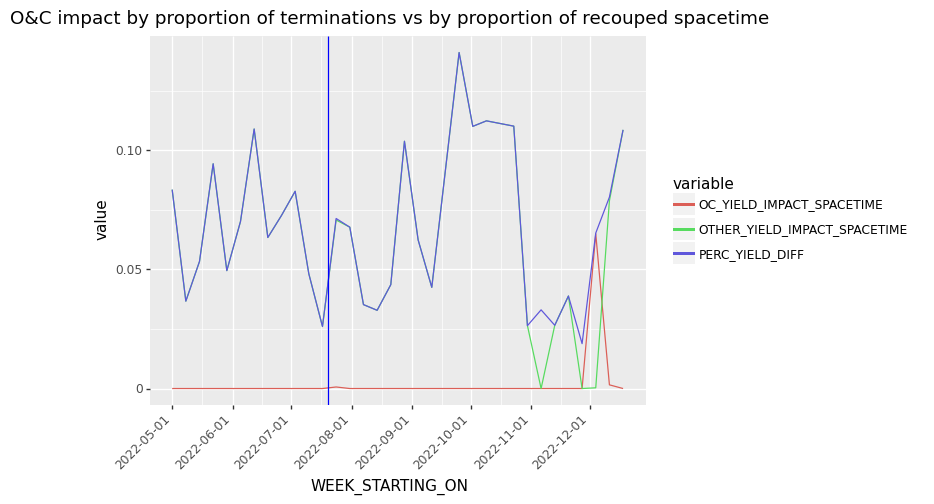

<ggplot: (362548493)>

In [9]:
(
    df
    .filter(items=['WEEK_STARTING_ON','PERC_YIELD_DIFF','OC_YIELD_IMPACT_SPACETIME','OTHER_YIELD_IMPACT_SPACETIME'])
    .pipe(lambda d: pd.melt(d, id_vars='WEEK_STARTING_ON'))
    .assign(WEEK_STARTING_ON = lambda d: pd.to_datetime(d['WEEK_STARTING_ON']))

    
    .pipe(lambda d: ggplot(d, aes(x='WEEK_STARTING_ON',y='value',color='variable')) 
          + geom_line()
          + theme(axis_text_x=element_text(rotation=45,hjust=1))
          + geom_vline(xintercept=datetime.date(2022,7,20),color='blue')
#           + scale_y_log10()
#           + labs(y='Yield Impact\n(log scale)')
          + ggtitle("O&C impact by proportion of terminations vs by proportion of recouped spacetime")
         )
)

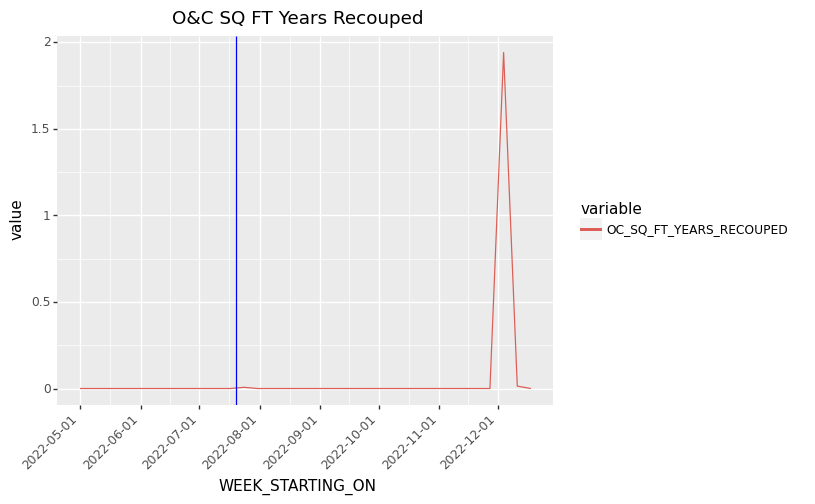

<ggplot: (362599924)>

In [10]:
(
    df
    .filter(items=['WEEK_STARTING_ON','OC_SQ_FT_YEARS_RECOUPED'])
    .pipe(lambda d: pd.melt(d, id_vars='WEEK_STARTING_ON'))
    .assign(WEEK_STARTING_ON = lambda d: pd.to_datetime(d['WEEK_STARTING_ON']))

    
    .pipe(lambda d: ggplot(d, aes(x='WEEK_STARTING_ON',y='value',color='variable')) 
          + geom_line()
          + theme(axis_text_x=element_text(rotation=45,hjust=1))
          + geom_vline(xintercept=datetime.date(2022,7,20),color='blue')
#           + scale_y_log10()
#           + labs(y='Yield Impact\n(log scale)')
          + ggtitle("O&C SQ FT Years Recouped")
         )
)

In [11]:
qry = """
  with crops as (
    select *
    from warehouse.dm_crops
    where farm_id =2 
      and yield_attributed_on between '2022-05-01' and '2022-12-31'
      and outcome = 'terminated'
  )
  select
"""